In [1]:
#import IterativeBacktest-RTM as IB
from BBBacktesterModule import *
static_spread = 1.4
pips = 0.0001

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")


class IterativeBase():
    ''' Base class for iterative (event-driven) backtesting of trading strategies.
    '''

    def __init__(self, symbol, start, end, amount, use_spread = True):
        '''
        Parameters
        ----------
        symbol: str
            ticker symbol (instrument) to be backtested
        start: str
            start date for data import
        end: str
            end date for data import
        amount: float
            initial amount to be invested per trade
        use_spread: boolean (default = True) 
            whether trading costs (bid-ask spread) are included
        '''
        self.symbol = symbol
        self.start = start
        self.end = end
        self.initial_balance = amount
        self.current_balance = amount
        self.units = 0
        self.trades = 0
        self.position = 0
        self.use_spread = use_spread
        self.get_data()
    
    def get_data(self):
        ''' Imports the data from detailed.csv (source can be changed).
        '''
        raw = pd.read_csv("detailed.csv", parse_dates = ["time"], index_col = "time").dropna()
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw

    def plot_data(self, cols = None):  
        ''' Plots the closing price for the symbol.
        '''
        if cols is None:
            cols = "price"
        self.data[cols].plot(figsize = (12, 8), title = self.symbol)
    
    def get_values(self, bar):
        ''' Returns the date, the price and the spread for the given bar.
        '''
        date = str(self.data.index[bar].date())
        price = round(self.data.price.iloc[bar], 5)
        spread = round(self.data.spread.iloc[bar], 5)
        return date, price, spread
    
    def print_current_balance(self, bar):
        ''' Prints out the current (cash) balance.
        '''
        date, price, spread = self.get_values(bar)
        print("{} | Current Balance: {}".format(date, round(self.current_balance, 2)))
        
    def buy_instrument(self, bar, units = None, amount = None):
        ''' Places and executes a buy order (market order).
        '''
        date, price, spread = self.get_values(bar)
        if self.use_spread:
            price += spread/2 # ask price
        if amount is not None: # use units if units are passed, otherwise calculate units
            units = int(amount / price)
        self.current_balance -= units * price # reduce cash balance by "purchase price"
        self.units += units
        self.trades += 1
        print("{} |  Buying {} for {}".format(date, units, round(price, 5)))
    
    def sell_instrument(self, bar, units = None, amount = None):
        ''' Places and executes a sell order (market order).
        '''
        date, price, spread = self.get_values(bar)
        if self.use_spread:
            price -= spread/2 # bid price
        if amount is not None: # use units if units are passed, otherwise calculate units
            units = int(amount / price)
        self.current_balance += units * price # increases cash balance by "purchase price"
        self.units -= units
        self.trades += 1
        print("{} |  Selling {} for {}".format(date, units, round(price, 5)))
    
    def print_current_position_value(self, bar):
        ''' Prints out the current position value.
        '''
        date, price, spread = self.get_values(bar)
        cpv = self.units * price
        print("{} |  Current Position Value = {}".format(date, round(cpv, 2)))
    
    def print_current_nav(self, bar):
        ''' Prints out the current net asset value (nav).
        '''
        date, price, spread = self.get_values(bar)
        nav = self.current_balance + self.units * price
        print("{} |  Net Asset Value = {}".format(date, round(nav, 2)))
        
    def close_pos(self, bar):
        ''' Closes out a long or short position (go neutral).
        '''
        date, price, spread = self.get_values(bar)
        print(75 * "-")
        print("{} | +++ CLOSING FINAL POSITION +++".format(date))
        self.current_balance += self.units * price # closing final position (works with short and long!)
        self.current_balance -= (abs(self.units) * spread/2 * self.use_spread) # substract half-spread costs
        print("{} | closing position of {} for {}".format(date, self.units, price))
        self.units = 0 # setting position to neutral
        self.trades += 1
        perf = (self.current_balance - self.initial_balance) / self.initial_balance * 100
        self.print_current_balance(bar)
        print("{} | net performance (%) = {}".format(date, round(perf, 2) ))
        print("{} | number of trades executed = {}".format(date, self.trades))
        print(75 * "-")
        
###########separate into 2 .py files here########        
#from IterativeBase import *        
        
class IterativeBacktest(IterativeBase):
    ''' Class for iterative (event-driven) backtesting of trading strategies.
    '''

    # helper method
    def go_long(self, bar, units = None, amount = None):
        if self.position == -1:
            self.buy_instrument(bar, units = -self.units) # if short position, go neutral first
        if units:
            self.buy_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.current_balance
            self.buy_instrument(bar, amount = amount) # go long

    # helper method
    def go_short(self, bar, units = None, amount = None):
        if self.position == 1:
            self.sell_instrument(bar, units = self.units) # if long position, go neutral first
        if units:
            self.sell_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.current_balance
            self.sell_instrument(bar, amount = amount) # go short

    def test_sma_strategy(self, SMA_S, SMA_L):
        ''' 
        Backtests an SMA crossover strategy with SMA_S (short) and SMA_L (long).
        
        Parameters
        ----------
        SMA_S: int
            moving window in bars (e.g. days) for shorter SMA
        SMA_L: int
            moving window in bars (e.g. days) for longer SMA
        '''
        
        # nice printout
        stm = "Testing SMA strategy | {} | SMA_S = {} & SMA_L = {}".format(self.symbol, SMA_S, SMA_L)
        print("-" * 75)
        print(stm)
        print("-" * 75)
        
        # reset 
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.current_balance = self.initial_balance  # reset initial capital
        self.get_data() # reset dataset
        
        # prepare data
        self.data["SMA_S"] = self.data["price"].rolling(SMA_S).mean()
        self.data["SMA_L"] = self.data["price"].rolling(SMA_L).mean()
        self.data.dropna(inplace = True)

        # sma crossover strategy
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            if self.data["SMA_S"].iloc[bar] > self.data["SMA_L"].iloc[bar]: # signal to go long
                if self.position in [0, -1]:
                    self.go_long(bar, amount = "all") # go long with full amount
                    self.position = 1  # long position
            elif self.data["SMA_S"].iloc[bar] < self.data["SMA_L"].iloc[bar]: # signal to go short
                if self.position in [0, 1]:
                    self.go_short(bar, amount = "all") # go short with full amount
                    self.position = -1 # short position
        self.close_pos(bar+1) # close position at the last bar
        
        
    def test_con_strategy(self, window = 1):
        ''' 
        Backtests a simple contrarian strategy.
        
        Parameters
        ----------
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        
        # nice printout
        stm = "Testing Contrarian strategy | {} | Window = {}".format(self.symbol, window)
        print("-" * 75)
        print(stm)
        print("-" * 75)
        
        # reset 
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.current_balance = self.initial_balance  # reset initial capital
        self.get_data() # reset dataset
        
        # prepare data
        self.data["rolling_returns"] = self.data["returns"].rolling(window).mean()
        self.data.dropna(inplace = True)
        
        # Contrarian strategy
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            if self.data["rolling_returns"].iloc[bar] <= 0: #signal to go long
                if self.position in [0, -1]:
                    self.go_long(bar, amount = "all") # go long with full amount
                    self.position = 1  # long position
            elif self.data["rolling_returns"].iloc[bar] > 0: #signal to go short
                if self.position in [0, 1]:
                    self.go_short(bar, amount = "all") # go short with full amount
                    self.position = -1 # short position
        self.close_pos(bar+1) # close position at the last bar
        
        
    def test_boll_strategy(self, SMA, dev):
        ''' 
        Backtests a Bollinger Bands mean-reversion strategy.
        
        Parameters
        ----------
        SMA: int
            moving window in bars (e.g. days) for simple moving average.
        dev: int
            distance for Lower/Upper Bands in Standard Deviation units
        '''
        
        # nice printout
        stm = "Testing Bollinger Bands Strategy | {} | SMA = {} & dev = {}".format(self.symbol, SMA, dev)
        print("-" * 75)
        print(stm)
        print("-" * 75)
        
        # reset 
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.current_balance = self.initial_balance  # reset initial capital
        self.get_data() # reset dataset
        
        # prepare data
        self.data["SMA"] = self.data["price"].rolling(SMA).mean()
        self.data["Lower"] = self.data["SMA"] - self.data["price"].rolling(SMA).std() * dev
        self.data["Upper"] = self.data["SMA"] + self.data["price"].rolling(SMA).std() * dev
        self.data.dropna(inplace = True)
        
        # Bollinger strategy
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            if self.position == 0: # when neutral
                if self.data["price"].iloc[bar] < self.data["Lower"].iloc[bar]: # signal to go long
                    self.go_long(bar, amount = "all") # go long with full amount
                    self.position = 1  # long position
                elif self.data["price"].iloc[bar] > self.data["Upper"].iloc[bar]: # signal to go Short
                    self.go_short(bar, amount = "all") # go short with full amount
                    self.position = -1 # short position
            elif self.position == 1: # when long
                if self.data["price"].iloc[bar] > self.data["SMA"].iloc[bar]:
                    if self.data["price"].iloc[bar] > self.data["Upper"].iloc[bar]: # signal to go short
                        self.go_short(bar, amount = "all") # go short with full amount
                        self.position = -1 # short position
                    else:
                        self.sell_instrument(bar, units = self.units) # go neutral
                        self.position = 0
            elif self.position == -1: # when short
                if self.data["price"].iloc[bar] < self.data["SMA"].iloc[bar]:
                    if self.data["price"].iloc[bar] < self.data["Lower"].iloc[bar]: # signal to go long
                        self.go_long(bar, amount = "all") # go long with full amount
                        self.position = 1 # long position
                    else:
                        self.buy_instrument(bar, units = -self.units) # go neutral
                        self.position = 0                
        self.close_pos(bar+1) # close position at the last bar

    def test_boll_strategy(self, SMA, dev):
        ''' 
        Backtests a Bollinger Bands mean-reversion strategy.
        
        Parameters
        ----------
        SMA: int
            moving window in bars (e.g. days) for simple moving average.
        dev: int
            distance for Lower/Upper Bands in Standard Deviation units
        '''
        
        # nice printout
        stm = "Testing Bollinger Bands Strategy | {} | SMA = {} & dev = {}".format(self.symbol, SMA, dev)
        print("-" * 75)
        print(stm)
        print("-" * 75)
        
        # reset 
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.current_balance = self.initial_balance  # reset initial capital
        self.get_data() # reset dataset
        
        # prepare data
        self.data["SMA"] = self.data["price"].rolling(SMA).mean()
        self.data["Lower"] = self.data["SMA"] - self.data["price"].rolling(SMA).std() * dev
        self.data["Upper"] = self.data["SMA"] + self.data["price"].rolling(SMA).std() * dev
        self.data.dropna(inplace = True) 
        
        # Bollinger strategy
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            if self.position == 0: # when neutral
                if self.data["price"].iloc[bar] < self.data["Lower"].iloc[bar]: # signal to go long
                    self.go_long(bar, amount = "all") # go long with full amount
                    self.position = 1  # long position
                elif self.data["price"].iloc[bar] > self.data["Upper"].iloc[bar]: # signal to go Short
                    self.go_short(bar, amount = "all") # go short with full amount
                    self.position = -1 # short position
            elif self.position == 1: # when long
                if self.data["price"].iloc[bar] > self.data["SMA"].iloc[bar]:
                    if self.data["price"].iloc[bar] > self.data["Upper"].iloc[bar]: # signal to go short
                        self.go_short(bar, amount = "all") # go short with full amount
                        self.position = -1 # short position
                    else:
                        self.sell_instrument(bar, units = self.units) # go neutral
                        self.position = 0
            elif self.position == -1: # when short
                if self.data["price"].iloc[bar] < self.data["SMA"].iloc[bar]:
                    if self.data["price"].iloc[bar] < self.data["Lower"].iloc[bar]: # signal to go long
                        self.go_long(bar, amount = "all") # go long with full amount
                        self.position = 1 # long position
                    else:
                        self.buy_instrument(bar, units = -self.units) # go neutral
                        self.position = 0                
        self.close_pos(bar+1) # close position at the last bar

## Optimize parameters and vector backtest

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = c | FREQ = 61 | SMA = 130 | DEV = 2
----------------------------------------------------------------------------------------------------


PERFORMANCE MEASURES:


Multiple (Strategy):         8.920196
Multiple (Buy-and-Hold):     0.867237
--------------------------------------
Out-/Underperformance:       8.052959


CAGR:                        0.316591
Annualized Mean:             0.274967
Annualized Std:              0.415206
Sharpe Ratio:                0.662243
Sortino Ratio:               0.942733
Maximum Drawdown:            0.357052
Calmar Ratio:                0.886681
Max Drawdown Duration:       274 Days
Kelly Criterion:             2.087604
SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = c | FREQ = 61 | SMA = 130 | DEV = 2
----------------------------------------------------------------------------------------------------


PERFORMANCE MEASURES:


Multiple (Strategy):         1.557525
Multiple (Buy-and-Hold):     0.867237
-----------------

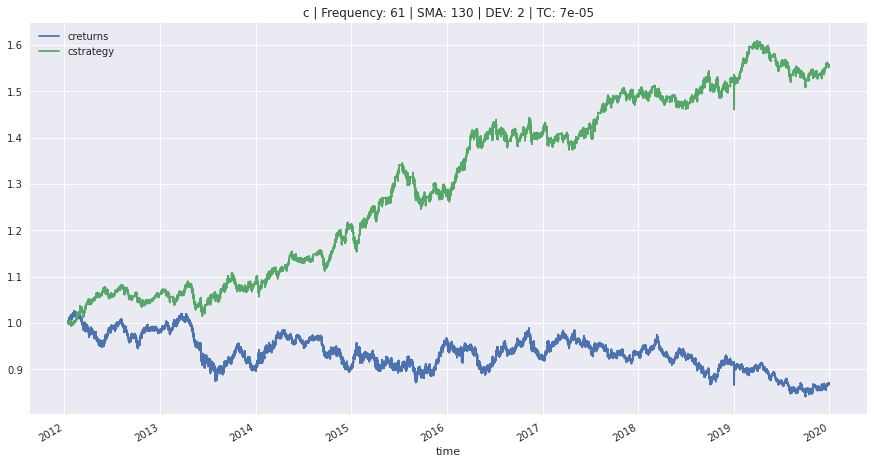

In [3]:
tester = BBBacktester("AUD_CAD_Full_OHLCV.csv", "c", "2012-01-01", "2019-12-31", static_spread*pips/2) 
tester.test_strategy(freq=1440, sma=40, dev = 1.8888)
tester.test_strategy(freq=61, sma=130, dev = 2)

        #mult by 2 for a 'round trip', multiply by pips
#tester.optimize_strategy((1,1440,60),(10,150,40),(1,2,10), metric = "Sharpe") #quick
half_kelly = (tester.calculate_kelly_criterion(tester.results.strategy))/2
tester.add_leverage(leverage = half_kelly, sl = -0.35)
tester.plot_results(leverage = False)
tester.print_performance(0)

## Test parameters on forward data

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = c | FREQ = 61 | SMA = 130 | DEV = 2
----------------------------------------------------------------------------------------------------


PERFORMANCE MEASURES:


Multiple (Strategy):         1.247176
Multiple (Buy-and-Hold):     1.027260
--------------------------------------
Out-/Underperformance:       0.219916


CAGR:                        0.119624
Annualized Mean:             0.113058
Annualized Std:              0.271655
Sharpe Ratio:                0.416182
Sortino Ratio:               0.594675
Maximum Drawdown:            0.277724
Calmar Ratio:                0.430730
Max Drawdown Duration:       185 Days
Kelly Criterion:             2.031004


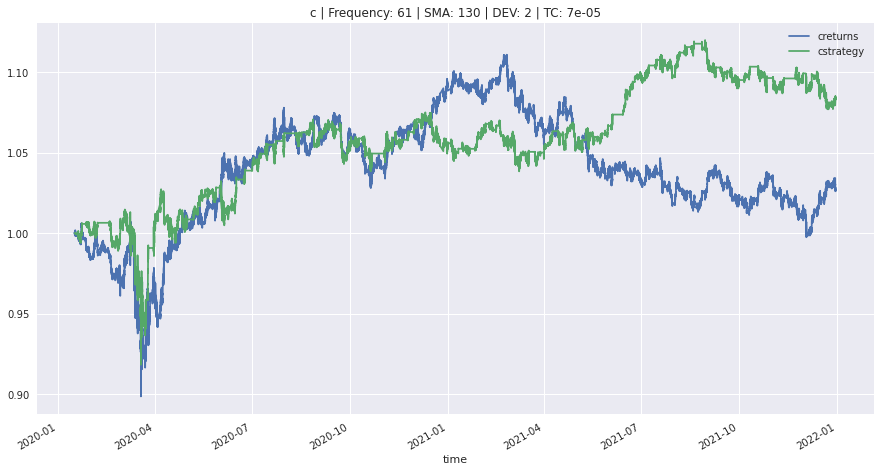

In [6]:
#tester = BBBacktester("detailed.csv", "price", "2020-01-01", "2021-12-31", spread*pips/2) #mult by 2 for a 'round trip', multiply by pips

#best = tester.results_overview.nlargest(1,columns='Performance')

forward = BBBacktester("AUD_CAD_Full_OHLCV.csv", "c", "2020-01-01", "2021-12-31", static_spread*pips/2) #mult by 2 for a 'round trip', multiply by pips
#forward.test_strategy(freq=best.Freq.values[0], sma=int(best.Sma.values[0]), dev = best.Dev.values[0])
forward.test_strategy(freq=61, sma=130, dev = 2)

fw_half_kelly = (forward.calculate_kelly_criterion(forward.results.strategy))/2
forward.add_leverage(leverage = fw_half_kelly, sl = -0.35)
forward.plot_results(leverage=False)

In [ ]:
best.Sma.values[0]

## Run iterative backtest on best strategy

In [12]:
bc = IterativeBacktest("c", "2007-01-01", "2019-12-31", 100000, use_spread= True)
bc.test_boll_strategy(90, 1)

---------------------------------------------------------------------------
Testing Bollinger Bands Strategy | c | SMA = 90 & dev = 1
---------------------------------------------------------------------------
2007-04-10 |  Selling 74456 for 1.34307
2007-06-07 |  Buying 74456 for 1.33784
2007-07-01 |  Selling 73691 for 1.36229
2007-08-13 |  Buying 73691 for 1.35337
2007-09-06 |  Selling 73419 for 1.3763
2007-12-19 |  Buying 73419 for 1.43302
2007-12-27 |  Selling 65824 for 1.47183
2008-01-20 |  Buying 65824 for 1.44548
2008-01-27 |  Selling 66719 for 1.47808
2008-02-05 |  Buying 66719 for 1.46329
2008-02-06 |  Buying 68761 for 1.44854
2008-02-14 |  Selling 68761 for 1.4677
2008-02-20 |  Selling 68127 for 1.48136
2008-06-01 |  Buying 68127 for 1.55378
2008-06-11 |  Buying 62169 for 1.54396
2008-06-24 |  Selling 62169 for 1.56661
2008-06-26 |  Selling 61684 for 1.57893
2008-07-28 |  Buying 61684 for 1.55887
2008-08-04 |  Buying 63820 for 1.54548
2008-12-10 |  Selling 63820 for 1.33508
20